In [1]:
# libraries import

from stats_can import StatsCan # to retrieve statistics canada data
import datetime as dt # for date analysis
import numpy as np # for numerical analysis
import pandas as pd # for data frames
import matplotlib.pyplot as plt # for chart visualization 
import matplotlib.ticker as ticker # for chart label formatting 
import matplotlib.dates as mdates # for chart date formatting
import getpass # for csv export testing 
import os # for csv export testing 
import itertools as it # for combination analysis

In [2]:
# StatsCan data retrieval

# note that requires at least 2016 or earlier since start year and end year (less 1)
# will be excluded and centred moving average excludes Jan-Jun and Jul-Dec  
start_year = 2016 # input sales start (inclusive)
end_year = 2020 # input for sales end (exclusive) used in data frame cleaning cell

# number of months since start period
# may get a few additional months before 2015 depending on lag of current month relase 
end_date = dt.date(dt.datetime.now().year,dt.datetime.now().month,1)
start_date = dt.date(start_year,1,1) 
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

# set retrieval parameters, apply labels, append all to a dataframe
df_key = pd.DataFrame({"vctr_id":['v52367258','v52367262','v52367228','v52367232',\
                                   '52367198','v52367202','v52367168','v52367172'], 
                       "prv_nm":['BC','BC','AB','AB','SK','SK','MB','MB'], 
                       "prv_id":[0,0,1,1,2,2,3,3], 
                       "cat_nm":['ClothesEtc','HobbyEtc','ClothesEtc','HobbyEtc',\
                                        'ClothesEtc','HobbyEtc','ClothesEtc','HobbyEtc'],
                       "cat_id":[0,1,0,1,0,1,0,1]})
rows = len(df_key)
incrementer = 0
df_sales = df = pd.DataFrame(columns = ['vctr_id', 'prv_nm', 'prv_id',\
                                        'cat_nm', 'cat_id', 'sales_K']) 
sc = StatsCan()

while incrementer < rows:
    
    # variables for data frame population
    vid = df_key.iloc[incrementer, df_key.columns.get_loc('vctr_id')]
    prv_nm = df_key.iloc[incrementer, df_key.columns.get_loc('prv_nm')] 
    prv_id = df_key.iloc[incrementer, df_key.columns.get_loc('prv_id')] 
    ctg_nm = df_key.iloc[incrementer, df_key.columns.get_loc('cat_nm')]
    ctg_id = df_key.iloc[incrementer, df_key.columns.get_loc('cat_id')]
    
    # retrieve data from stats can 
    df = sc.vectors_to_df_remote(vid, periods=num_months)
    df.index.names = ['date']
    df = df.stack().reset_index() #flatten table
    df = df.rename(columns={'level_1': 'vctr_id', 0: 'sales_k'})
    df.insert(2,'year', df.date.dt.year)
    df.insert(3,'qtr', df.date.dt.quarter)
    df.insert(4,'mon', df.date.dt.month)
    df.insert(5,'prv_nm',prv_nm)
    df.insert(6,'prv_id',prv_id)
    df.insert(7,'cat_nm',ctg_nm)
    df.insert(8,'cat_id',ctg_id)
    df_sales = df_sales.append(df, ignore_index = True)
    
    incrementer += 1       

In [3]:
# data frame cleaning

# exclude any additional months included due to lag in release versus calendar months
# input start_year is from get stats can cell
df_sales = df_sales.loc[ (df_sales['year'] >= start_year) & (df_sales['year'] < end_year)  ] 
df_sales.sort_values(by=['prv_id','cat_id','date'])
df_sales = df_sales[['date','year','qtr','mon','prv_nm','prv_id','cat_nm','cat_id','sales_k']]
df_sales["year"] = df_sales["year"].astype(int) 
df_sales["qtr"] = df_sales["qtr"].astype(int) 
df_sales["mon"] = df_sales["mon"].astype(int) 
df_sales.insert(4,'qtr_convert', df_sales.qtr.apply(lambda x: '0' + np.str(x) if x < 10 else np.str(x)))
df_sales.insert(5,'mon_convert', df_sales.mon.apply(lambda x: '0' + np.str(x) if x < 10 else np.str(x)))
df_sales.insert(6,'qtr_period', df_sales.year.astype(str) + "-" + df_sales.qtr_convert)
df_sales.insert(7,'mon_period', df_sales.year.astype(str) + "-" + df_sales.mon_convert)

# lists for visualization and scenario combinations
categories = df_sales.cat_nm.unique().tolist()
provinces = df_sales.prv_nm.unique().tolist()

# create time series up to last full year to ensure queried data is aligned  
period = pd.DataFrame(df_sales.mon_period.unique(), columns=["mon_period"]) # convert array to data frame to access index 

<Figure size 3000x1000 with 0 Axes>

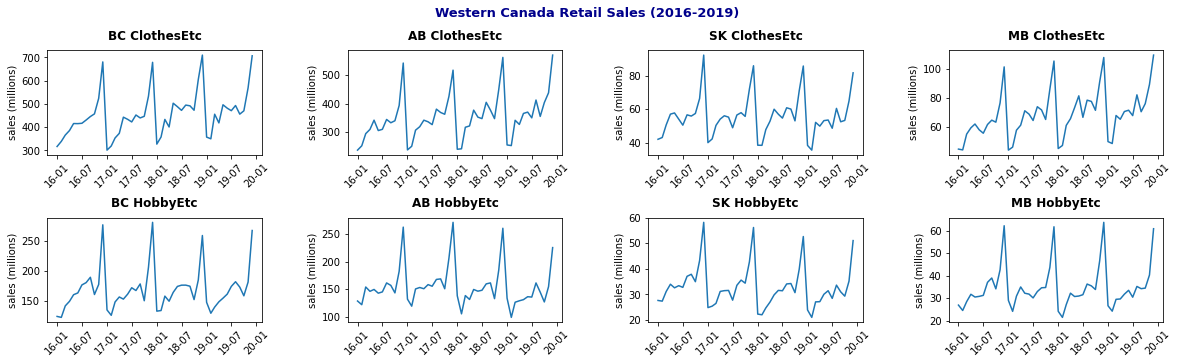

In [4]:
# actual sales seasonality display

# create figure and axes layout
fig = plt.figure(num = 1, figsize = (30, 10), dpi = 100, facecolor = 'w', edgecolor = 'k')
fig, ax = plt.subplots(2,4, figsize = (20,5)) # axes layout with category on row and province on column 
fig.subplots_adjust(hspace=0.6, wspace=0.4)
fig.suptitle('Western Canada Retail Sales (2016-2019)', fontsize=13, y=1.0, color='darkblue', fontweight='bold')

# initialize counters
cat_incrementer = 0
prv_incrementer = 0

for category in categories:
    
    # logic to position visualization in respective axes of the figure by row and column    
    if prv_incrementer == 4:
        prv_incrementer = 0
    else:
        prv_incrementer
    
    for province in provinces:
        
        # select actual sales for each province and category
        df_display_sales = df_sales[(df_sales.prv_nm == province) & (df_sales.cat_nm == category)]
      
        # plot and format sales
        ax[cat_incrementer,prv_incrementer].plot(df_display_sales.date, df_display_sales.sales_k)
        ax[cat_incrementer,prv_incrementer].set_title(province + " " + category, fontweight='bold', pad=10.5)
        ax[cat_incrementer,prv_incrementer].xaxis.set_tick_params(rotation=45)
        scale_y = 1000
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
        ax[cat_incrementer,prv_incrementer].yaxis.set_major_formatter(ticks_y)
        ax[cat_incrementer,prv_incrementer].set_ylabel('sales (millions)')
    
        # format dates
        dateFmt = mdates.DateFormatter("%y-%m")
        ax[cat_incrementer,prv_incrementer].xaxis.set_major_formatter(dateFmt)
        
        prv_incrementer += 1
      
    cat_incrementer += 1

In [5]:
# forecast parameters input 
fcst_frequency = 1 # input only 1, 2 or 4 (annually, semi-annually or quarterly)
fcst_window = int(12/fcst_frequency) # forecast period in months until start of next forecast
ma_windows = [2,3,4,5,6]
weight_increment = 0.1
list_weights = np.arange(weight_increment,1,weight_increment).tolist()

In [6]:
# forecast data frames indices

# forecast indices are the starting index positions for each forecast window 
# e.g. annual 12 month forecasts for observations starting January 2015 to December 2019 (5 years)
# will use 2015 as the first seed year, so 2016 to 2019 (4 years) 
# will have 4 index positions for January of each year, i.e. 12, 24, 36, 48 (zero-base indexing)

all_indices = period.index.to_list()
fcst_indices = list([x for x in all_indices if ( int(x) % (12/fcst_frequency) ) == 0 and int(x) > 10 ])

# remove indices that result in forecasts extending beyond observations
fcst_indices = [item for item in fcst_indices if (item + fcst_window) <= len(period)] 

In [7]:
# obtain forecast scenario combinations before applying weights of province, category, moving average, forecast 

scenario_dimensions = []
scenario_dimensions.append(provinces)
scenario_dimensions.append(categories)
scenario_dimensions.append(ma_windows)
scenario_dimensions.append(fcst_indices)
scenarios_lol = list(it.product(*scenario_dimensions)) 
scenarios_df = pd.DataFrame.from_records(scenarios_lol)
scenarios_df = scenarios_df.rename(columns={0: 'prv_nm', 1: 'cat_nm', 2: 'ma', 3:'fcst_idx'})

In [8]:
# initalize loop for list of weights and append lists of weights for each period in moving average window
# then join to scenarios data frame

df_weights_1 = pd.DataFrame([]) # initialize data frame

for x in ma_windows:
    
    # initialize list of list and counter
    lol_weights = []
    weights_counter = 0
    
    while weights_counter < x:
        
        lol_weights.append(list_weights)
        weights_counter += 1
        
        # all combinations of list of weights then filtered for combinations that equal 100%
        # NOTE: watch for rounding differences when converting between df and lol
        
        combo_weights = list(it.product(*lol_weights))
        df_weights = pd.DataFrame(combo_weights).round(1)
        df_weights['total'] = df_weights.sum(axis=1).round(1)
        df_weights = df_weights[df_weights.total == 1].reset_index(drop=True)
        df_weights = df_weights.drop(columns=['total'])
        df_weights.insert (0, 'ma', int(x))
        
    df_weights_1 = df_weights_1.append(df_weights)
  
scenarios_df_1 = pd.merge(scenarios_df, df_weights_1,  how='outer', on='ma')
scenarios_lol_1 = scenarios_df_1.values.tolist()

In [12]:
# get all combinations of provinces and categories then perform deseasonalization
# add related deseasonalization columns to original sales data frame
# display adjusted seasonality index 

# initialize list and data frames 
prv_cat_lol = []
prv_cat_lol.append(provinces)
prv_cat_lol.append(categories)
prv_cat_lol_1 = list(it.product(*prv_cat_lol)) 
sales_deseasonalized_df = pd.DataFrame([]) # used for forecasting
adj_season_idx_df = pd.DataFrame([]) # used for displaying seasonal index

prv_cat_lol_incrementer = 0 # initialize counter

for x in prv_cat_lol_1:
    
    # filter sales data frame based on province and category combination  
    category_df_1  = df_sales.loc[ (df_sales['prv_nm'] == prv_cat_lol_1[prv_cat_lol_incrementer][0]) & (df_sales['cat_nm'] == prv_cat_lol_1[prv_cat_lol_incrementer][1]) ]
    
    # join category sales of complete time series and add flag for volume observation
    data_combined = pd.merge(period, category_df_1, how='outer', on='mon_period')
    data_combined_1 = data_combined[ ['date', 'mon_period','year','qtr','mon','prv_id','cat_id','sales_k'] ].fillna(0)
    data_combined_1['prv_nm'] = prv_cat_lol_1[prv_cat_lol_incrementer][0]
    data_combined_1['cat_nm'] = prv_cat_lol_1[prv_cat_lol_incrementer][1]

    # get count of observations
    data_combined_1['obsrv_flag'] = data_combined_1['sales_k'].apply( lambda x: 1 if x > 0 else 0 )
    grouper = data_combined_1.groupby([pd.Grouper(key='year')])
    yr_count = grouper['obsrv_flag'].sum().to_frame(name='obsrv_count').reset_index()
    data_combined_2 = pd.merge(data_combined_1, yr_count, how='outer', on='year')

    # centred moving average for 12 months for specific seasonal 
    data_combined_2['cntr_ma_yr'] = (data_combined_2.sales_k.rolling(12, min_periods=12).mean().shift(-5) + 
                                           data_combined_2.sales_k.rolling(12, min_periods=12).mean().shift(-6) ) / 2
    data_combined_2['spec_season'] = data_combined_2['sales_k'] / data_combined_2['cntr_ma_yr']

    # seasonal index 
    first_yr_seasonal_index = data_combined_2['year'].min()
    last_yr_seasonal_index = data_combined_2['year'].max()
    data_seasonal_index = data_combined_2[(data_combined_2.year > first_yr_seasonal_index) & (data_combined_2.year < last_yr_seasonal_index)]
    grouper = data_seasonal_index.groupby([pd.Grouper(key='mon')])
    mon_specific_seasonal_index = grouper['spec_season'].sum().to_frame(name='spec_season_sum').reset_index()
    # years with complete specific seasonal values due to time series out of cma year 
    # (Jan-Jun first year and Jul to Dec last year)
    complete_seasonal_specific_yr = ( data_seasonal_index['year'].nunique())  
    mon_specific_seasonal_index['spec_season_avg'] = mon_specific_seasonal_index['spec_season_sum'] / complete_seasonal_specific_yr
    total_specific_seasonal_mean = mon_specific_seasonal_index['spec_season_avg'].sum()
    periods_count = df_sales.mon.nunique() # unique() returns an array and nunique() a number

    # correction factor for rounding to force indexes to total the number of periods
    mon_specific_seasonal_index['adj_season_idx'] = mon_specific_seasonal_index['spec_season_avg'] * ( periods_count / total_specific_seasonal_mean ) 

    data_combined_3 = pd.merge(data_combined_2, mon_specific_seasonal_index, how='outer', on='mon')
    data_combined_3['sales_deseason'] = data_combined_3['sales_k'] / data_combined_3['adj_season_idx'] 

    # assign to new variable for sort to work
    data_combined_4 = data_combined_3[ ['date','mon_period', 'year', 'qtr', 'mon',  'prv_nm', 'prv_id', 'cat_nm', 'cat_id', 'sales_k', 'obsrv_count', 'cntr_ma_yr', 'spec_season', 
                      'spec_season_sum', 'spec_season_avg', 'adj_season_idx', 'sales_deseason'] ].fillna(0).sort_values( by=['prv_id', 'cat_id', 'mon_period']).reset_index(drop = True)
    
    # append results to new data frame used for forecasting
    sales_deseasonalized_df = sales_deseasonalized_df.append(data_combined_4)
    
    # create data frame to view adjusted seasonal index
    mon_specific_seasonal_index.insert(0, 'prv_cat', prv_cat_lol_1[prv_cat_lol_incrementer][0] + '_' + prv_cat_lol_1[prv_cat_lol_incrementer][1])
    adj_season_idx_df = adj_season_idx_df.append(mon_specific_seasonal_index)
    adj_season_idx_df_1 = adj_season_idx_df[ ['prv_cat', 'mon', 'adj_season_idx'] ]
    
    # advance incrementer
    prv_cat_lol_incrementer += 1

# pivot adjusted seasonal index data frame and format for display     
adj_idx_df = adj_season_idx_df_1.pivot(index='prv_cat',columns='mon', values='adj_season_idx') # transpose values column wise
adj_idx_df.reset_index(inplace=True) # flatten multi index
adj_idx_df.rename_axis(None, axis=1, inplace=True) # remove 'mon' on column and note that the it is not the index name

# assign a name to the index positions
adj_idx_df.rename( columns={adj_idx_df.columns[1]: '01', adj_idx_df.columns[2]: '02', adj_idx_df.columns[3]: '03', adj_idx_df.columns[4]: '04', adj_idx_df.columns[5]: '05', adj_idx_df.columns[6]: '06', \
                            adj_idx_df.columns[7]: '07', adj_idx_df.columns[8]: '08', adj_idx_df.columns[9]: '09', adj_idx_df.columns[10]: '10', adj_idx_df.columns[11]: '11', adj_idx_df.columns[12]: '12',}, inplace=True)

adj_idx_df.insert(13, 'Average', adj_idx_df.iloc[:, 1:13].mean(axis=1) )
adj_idx_df_1 = adj_idx_df.reindex([2,0,6,4,3,1,7,5]) # sort same order as de-/seasonalized graphs
adj_idx_df_1.reset_index(inplace=True, drop=True)
adj_idx_df_1[['Province','Category']] = adj_idx_df_1.prv_cat.str.split("_",expand=True)
adj_idx_df_1.drop(columns=['prv_cat'], inplace=True)
adj_idx_df_1 = adj_idx_df_1[ ['Province', 'Category', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 'Average'] ] 

# hide index, center and 2 decimal format values  
adj_idx_df_2 = adj_idx_df_1.style.hide_index().set_properties(**{'text-align': 'center'}).format("{:.2f}", subset=pd.IndexSlice[:, '01':'Average'])

# dislay adjusted seasonality index
adj_idx_df_2.set_table_styles([dict(selector = 'th', props=[('text-align', 'center')])]) # center column headers
adj_idx_df_2.background_gradient(subset=['01','02','03','04','05','06','07','08','09','10','11','12'], cmap='YlGn', axis=1)

print('\033[38;5;18m\033[1m' + '                   Seasonality Factors for Western Canada Retail Sales') # colour then bold text
adj_idx_df_2

                   Seasonality Factors for Western Canada Retail Sales


Province,Category,01,02,03,04,05,06,07,08,09,10,11,12,Average
BC,ClothesEtc,0.71,0.76,0.88,0.86,1.05,1.02,0.98,1.04,1.01,0.99,1.22,1.49,1.00
AB,ClothesEtc,0.69,0.71,0.89,0.91,1.02,0.97,0.95,1.10,1.05,0.99,1.22,1.50,1.00
SK,ClothesEtc,0.69,0.71,0.86,0.94,1.02,0.99,0.91,1.04,1.05,0.97,1.28,1.54,1.00
MB,ClothesEtc,0.66,0.69,0.86,0.92,1.04,1.07,0.93,1.08,1.05,0.96,1.24,1.49,1.00
BC,HobbyEtc,0.79,0.76,0.90,0.90,0.93,0.99,1.03,1.01,1.04,0.89,1.16,1.59,1.00
AB,HobbyEtc,0.84,0.70,0.89,0.88,0.93,0.95,0.94,1.02,1.03,0.89,1.24,1.69,1.00
SK,HobbyEtc,0.71,0.71,0.77,0.88,0.93,0.97,0.91,1.04,1.08,1.01,1.29,1.69,1.00
MB,HobbyEtc,0.76,0.65,0.83,0.97,0.90,0.90,0.88,0.99,1.01,0.99,1.30,1.81,1.00


<Figure size 3000x1000 with 0 Axes>

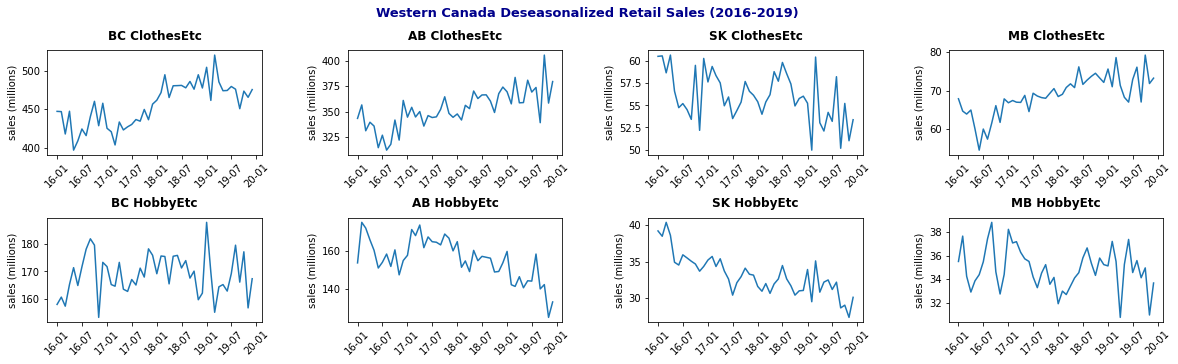

In [13]:
# view deseasonalized sales

# create figure and axes layout
fig = plt.figure(num = 1, figsize = (30, 10), dpi = 100, facecolor = 'w', edgecolor = 'k')
fig, ax = plt.subplots(2,4, figsize = (20,5)) # axes layout with category on row and province on column 
fig.subplots_adjust(hspace=0.6, wspace=0.4)
fig.suptitle('Western Canada Deseasonalized Retail Sales (2016-2019)', fontsize=13, y=1.0, color='darkblue', fontweight='bold')

cat_incrementer = 0
prv_incrementer = 0

for category in categories:
    
    # logic to position visualization in respective axes of the figure by row and column    
    if prv_incrementer == 4:
        prv_incrementer = 0
    else:
        prv_incrementer
    
    for province in provinces:
        
        # select actual sales for each province and category
        df_display_sales_deseasonalized = sales_deseasonalized_df[(sales_deseasonalized_df.prv_nm == province) & (sales_deseasonalized_df.cat_nm == category)]
        
        # plot and format sales
        ax[cat_incrementer,prv_incrementer].plot(df_display_sales_deseasonalized.date, df_display_sales_deseasonalized.sales_deseason)
        ax[cat_incrementer,prv_incrementer].set_title(province + " " + category, fontweight='bold', pad=10.5)
        ax[cat_incrementer,prv_incrementer].xaxis.set_tick_params(rotation=45) 
        scale_y = 1000
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
        ax[cat_incrementer,prv_incrementer].yaxis.set_major_formatter(ticks_y)
        ax[cat_incrementer,prv_incrementer].set_ylabel('sales (millions)')
    
        # format dates
        dateFmt = mdates.DateFormatter("%y-%m")
        ax[cat_incrementer,prv_incrementer].xaxis.set_major_formatter(dateFmt)
        
        prv_incrementer += 1
    
    cat_incrementer += 1

In [14]:
# forecast sales

sales_forecast_df = pd.DataFrame([]) # initialize data fram

for x in scenarios_lol_1: # each row of final scenarios data frame is a list 

    # set selection variables used to filter data frame
    scenario_idx = scenarios_lol_1.index(x)
    prv_nm = scenarios_lol_1[scenario_idx][0]
    cat_nm = scenarios_lol_1[scenario_idx][1]
    ma = scenarios_lol_1[scenario_idx][2]
    fcst_idx = scenarios_lol_1[scenario_idx][3]
    scenarios_lol_1[scenario_idx][4:(4+ma)]
    weights_list = scenarios_lol_1[scenario_idx][4:(4+ma)] # weights start to end position 

    # inialize counters
    fcst_counter = 1
    indx_counter = 0
    ma_list_start = 0
    ma_list_end = ma
    
    # filter data frame for each scenario
    sales_deseasonalized_df_1 = sales_deseasonalized_df.loc[ (sales_deseasonalized_df['prv_nm'] == prv_nm) & (sales_deseasonalized_df['cat_nm'] == cat_nm) ]
    
    # select only deseasonalized sales column for use in while loop
    sales_deseasonalized_col = sales_deseasonalized_df_1['sales_deseason']
    
    while fcst_counter < (fcst_window + 1) : # fcst_window from input parameters 

        if fcst_counter == 1:  
            ma_list = sales_deseasonalized_col.iloc[ (fcst_idx - ma) : fcst_idx ].values.tolist() # initial seed values

        else:
            ma_list
        
        # dot product for forecast sales value
        fcst_scalar = sum(x * y for x, y in zip( ma_list[ma_list_start : ma_list_end], weights_list ) )
        ma_list.append(fcst_scalar)
        
        # increment counters
        fcst_counter += 1 
        ma_list_start += 1
        ma_list_end += 1

    ma_df = pd.DataFrame(ma_list, columns=['fcst_deseason'])
    
    # select rows from deseasonalized sales data frame and add moving average, forecast item and weight fields 
    fcst_row_start = fcst_idx - ma # include seed values 
    fcst_row_end = fcst_idx + (fcst_window-1)
    sales_deseasonalized_df_2 = sales_deseasonalized_df_1.loc[ fcst_row_start : fcst_row_end ]
    sales_deseasonalized_df_2.insert(0, 'ma', str(ma))
    sales_deseasonalized_df_2.insert(1, 'fcst_item', np.where(sales_deseasonalized_df_2.index < fcst_idx, 'seed', 'estimate') )
    wgts_list = [x for x in weights_list if str(x) != 'nan'] 
    sales_deseasonalized_df_2.insert(0, 'wgts', '_ '.join([str(x) for x in wgts_list]))
    
    # join forecast values to deseasonalized sales data frame
    sales_deseasonalized_df_2.reset_index(inplace = True, drop = True) 
    sales_deseasonalized_df_3 = sales_deseasonalized_df_2.merge(ma_df, left_index=True, right_index=True)
    sales_forecast_df = sales_forecast_df.append(sales_deseasonalized_df_3)

# add other descriptive fields and calculate mape    
sales_forecast_df['fcst_scenario'] = sales_forecast_df['ma'] + '_' + sales_forecast_df['wgts']
sales_forecast_df['fcst_season'] = sales_forecast_df['fcst_deseason'] * sales_forecast_df['adj_season_idx']
sales_forecast_df['fcst_%_err'] = (sales_forecast_df['fcst_season'] / sales_forecast_df['sales_k'] - 1)  
sales_forecast_df['fcst_mape'] = np.abs( (sales_forecast_df['fcst_season'] / sales_forecast_df['sales_k'] - 1) )  

# reset index and select required fields for final sales forecast data frame 
sales_forecast_df.replace(np.inf, 0, inplace=True)
sales_forecast_df.reset_index(inplace = True, drop = True)
sales_forecast_df.insert(0,'index',sales_forecast_df.index)
sales_forecast_df_1 = sales_forecast_df[ ['index','date','mon_period','year','qtr','mon','prv_nm','cat_nm','fcst_scenario', 'fcst_item', 'sales_k',  
                                          'cntr_ma_yr','spec_season', 'spec_season_sum','spec_season_avg','adj_season_idx','sales_deseason',
                                          'fcst_deseason','fcst_season', 'fcst_%_err', 'fcst_mape'] ]

In [15]:
# obtain average mape and standard deviation over forecast scenario, i.e. moving average and weights combination
# obtain summary statistics over province and category

# initialize data frames and counter
mape_avg_df = pd.DataFrame([])
mape_std_df = pd.DataFrame([])
prv_cat_idx = 0

for x in prv_cat_lol_1:
    
    # set province and category to select from sales forecast data frame 
    prv_nm = prv_cat_lol_1[prv_cat_idx][0]
    cat_nm = prv_cat_lol_1[prv_cat_idx][1]
    
    # average
    fcst_mape_df = sales_forecast_df_1.loc[ (sales_forecast_df_1['prv_nm'] == prv_nm) & \
                                           (sales_forecast_df_1['cat_nm'] == cat_nm) & \
                                           (sales_forecast_df_1['fcst_item'] == 'estimate') ]
    fcst_mape_df_1 = fcst_mape_df[ ['prv_nm', 'cat_nm', 'fcst_scenario', 'fcst_mape'] ]
    fcst_mape_df_2 = fcst_mape_df_1.groupby( ['prv_nm', 'cat_nm', 'fcst_scenario'] ).mean() 
    mape_avg_df = mape_avg_df.append(fcst_mape_df_2)
    
    # standard deviation
    fcst_mape_df = sales_forecast_df_1.loc[ (sales_forecast_df_1['prv_nm'] == prv_nm) & \
                                           (sales_forecast_df_1['cat_nm'] == cat_nm) & \
                                           (sales_forecast_df_1['fcst_item'] == 'estimate') ]
    fcst_mape_df_1 = fcst_mape_df[ ['prv_nm', 'cat_nm', 'fcst_scenario', 'fcst_mape'] ]
    fcst_mape_df_2 = fcst_mape_df_1.groupby( ['prv_nm', 'cat_nm', 'fcst_scenario'] ).std() 
    mape_std_df = mape_std_df.append(fcst_mape_df_2)
    
    prv_cat_idx += 1

# average     
mape_avg_df.reset_index(inplace=True)    
mape_avg_df['fcst_mape'] = mape_avg_df['fcst_mape']*100 # express as percentages

# standard deviation
mape_std_df.reset_index(inplace=True)   
mape_std_df.rename( {'fcst_mape':'mape_std'}, axis=1, inplace=True) 
mape_std_df['mape_std'] = mape_std_df['mape_std']*100 # express as percentage
mape_std_df.drop( ['prv_nm','cat_nm','fcst_scenario'], axis=1, inplace=True)

# average and standard deviation combined
mape_avg_std_df = mape_avg_df.merge(mape_std_df, left_index=True, right_index=True)

# minimum mape of forecast scenario
mape_min_df = mape_avg_std_df.loc[mape_avg_std_df.groupby(['prv_nm','cat_nm']).fcst_mape.idxmin()].reset_index()
mape_min_df.drop(columns=['index'], inplace=True)
mape_min_df_1 = mape_min_df.reindex([2,0,6,4,3,1,7,5]) # sort same order as de-/seasonalized graphs
mape_min_df_1.rename( {'fcst_scenario':'min_scenario', 'fcst_mape':'min_mape', 'mape_std':'min_std'}, axis=1, inplace=True) 
 
# maximum mape of forecast scenario
mape_max_df = mape_avg_std_df.loc[mape_avg_std_df.groupby(['prv_nm','cat_nm']).fcst_mape.idxmax()].reset_index()
mape_max_df.drop(columns=['index'], inplace=True)
mape_max_df_1 = mape_max_df.reindex([2,0,6,4,3,1,7,5]) # sort same order as de-/seasonalized graphs
mape_max_df_1.rename( {'prv_nm':'max_prv_nm', 'cat_nm': 'max_cat_nm', 'fcst_scenario':'max_scenario', \
                       'fcst_mape':'max_mape', 'mape_std':'max_std'}, axis=1, inplace=True) # rename so can distinguish and drop in summary table

# average mape of all forecast scenarios
avg_mape_avg_df = mape_avg_std_df.groupby( ['prv_nm','cat_nm'] )[ ['fcst_mape'] ].mean()
avg_mape_avg_df.reset_index(inplace=True)
avg_mape_avg_df_1 = avg_mape_avg_df.reindex([2,0,6,4,3,1,7,5]) # sort same order as de-/seasonalized graphs
avg_mape_avg_df_1.rename( {'prv_nm':'avg_prv_nm', 'cat_nm': 'avg_cat_nm', \
                           'fcst_mape':'avg_mape'}, axis=1, inplace=True) # rename so can distinguish and drop in summary table

# median mape of all forecast scenarios; note that for an even length of forecasts median is an average of two middle terms, so cannot select fcst_scenario
mape_med_df = mape_avg_std_df.groupby( ['prv_nm','cat_nm'] )[ ['fcst_mape'] ].median()
mape_med_df.reset_index(inplace=True)
mape_med_df_1 = mape_med_df.reindex([2,0,6,4,3,1,7,5]) # sort same order as de-/seasonalized graphs
mape_med_df_1.rename( {'prv_nm':'med_prv_nm', 'cat_nm': 'med_cat_nm', \
                       'fcst_mape':'med_mape'}, axis=1, inplace=True) # rename so can distinguish and drop in summary table

# combine statistics into a single table based on minimum mape
stats_mape_df = mape_min_df_1.merge(mape_max_df_1, left_index=True, right_index=True)
stats_mape_df_1 = stats_mape_df.merge(avg_mape_avg_df_1, left_index=True, right_index=True)
stats_mape_df_2 = stats_mape_df_1.merge(mape_med_df_1, left_index=True, right_index=True)
stats_mape_df_2.drop( ['max_prv_nm','avg_prv_nm','med_prv_nm',\
                       'max_cat_nm','avg_cat_nm','med_cat_nm'], axis=1, inplace=True)
# format for display
fcst_stats_df = stats_mape_df_2.rename( {'prv_nm':'Province', 'cat_nm': 'Category', 'min_scenario':'Minimum Scenario', 'min_mape':'Minimum Scenario MAPE',\
                        'min_std':'Minimum Scenario Std. Dev.', 'max_scenario':'Maximum Scenario', 'max_mape':'Maximum Scenario MAPE', \
                        'max_std':'Maximum Scenario Std. Dev.', 'avg_mape': 'All Scenarios Avg. MAPE', 'med_mape': 'All Scenarios Med. MAPE'}, \
                       axis=1) # rename for display
fcst_stats_df_1 = fcst_stats_df.style.format("{:.2f}", \
                                               subset=pd.IndexSlice[:, ['Minimum Scenario MAPE', 'Minimum Scenario Std. Dev.', 'Maximum Scenario MAPE', 'Maximum Scenario Std. Dev.', 'All Scenarios Avg. MAPE', 'All Scenarios Med. MAPE'] ]).hide_index().set_properties(**{'text-align': 'center'})

# display data frame
print('\033[38;5;18m\033[1m' + '                                             Summary Statistics for Forecast Scenarios') # colour then bold text for title
fcst_stats_df_1.set_table_styles([dict(selector = 'th', props=[('text-align', 'center'),('max-width', '70px')])])  # center column headers and limit column width to wrap
fcst_stats_df_1.background_gradient(subset=['Minimum Scenario MAPE', 'Minimum Scenario Std. Dev.'], cmap='summer', axis=0)
fcst_stats_df_1.background_gradient(subset=['Maximum Scenario MAPE', 'Maximum Scenario Std. Dev.'], cmap='YlOrRd', axis=0)

                                             Summary Statistics for Forecast Scenarios


Province,Category,Minimum Scenario,Minimum Scenario MAPE,Minimum Scenario Std. Dev.,Maximum Scenario,Maximum Scenario MAPE,Maximum Scenario Std. Dev.,All Scenarios Avg. MAPE,All Scenarios Med. MAPE
BC,ClothesEtc,2_0.9_ 0.1,4.36,2.94,4_0.1_ 0.7_ 0.1_ 0.1,4.77,2.81,4.61,4.61
AB,ClothesEtc,4_0.2_ 0.1_ 0.1_ 0.6,2.72,2.36,5_0.6_ 0.1_ 0.1_ 0.1_ 0.1,4.00,2.40,3.26,3.28
SK,ClothesEtc,4_0.2_ 0.6_ 0.1_ 0.1,3.69,3.03,2_0.1_ 0.9,4.77,3.37,3.92,3.91
MB,ClothesEtc,2_0.1_ 0.9,3.16,2.54,6_0.5_ 0.1_ 0.1_ 0.1_ 0.1_ 0.1,5.54,3.14,4.64,4.68
BC,HobbyEtc,6_0.1_ 0.1_ 0.1_ 0.5_ 0.1_ 0.1,2.93,2.66,2_0.9_ 0.1,4.60,3.43,3.29,3.26
AB,HobbyEtc,2_0.1_ 0.9,6.65,4.08,2_0.9_ 0.1,7.42,3.57,7.17,7.19
SK,HobbyEtc,6_0.5_ 0.1_ 0.1_ 0.1_ 0.1_ 0.1,4.88,3.82,3_0.7_ 0.1_ 0.2,5.18,3.47,5.05,5.05
MB,HobbyEtc,5_0.1_ 0.5_ 0.1_ 0.1_ 0.2,3.63,3.49,2_0.9_ 0.1,4.59,3.86,3.87,3.83


<Figure size 3000x1000 with 0 Axes>

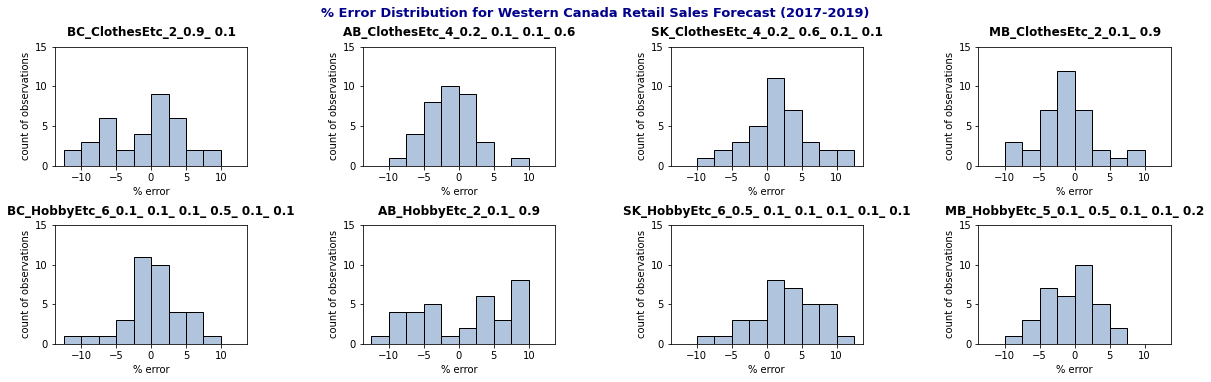

In [17]:
# visualize mape distribution

# convert summary statistics to a list of list in order to select respective absolute mape as well as actual and forecast sales 
stats_lol = stats_mape_df_2[ ['prv_nm','cat_nm','min_scenario'] ].values.tolist()

# create figure and axes layout
fig = plt.figure(num = 1, figsize = (30, 10), dpi = 100, facecolor = 'w', edgecolor = 'k')
fig, ax = plt.subplots(2,4, figsize = (20,5)) # axes layout with category on row and province on column 
fig.subplots_adjust(top=0.95, hspace=0.5, wspace=0.6)
fig.suptitle('% Error Distribution for Western Canada Retail Sales Forecast (2017-2019)', fontsize=13, y=1.06, color='darkblue', fontweight='bold')

stats_idx = 0 # initialize scenario counter

for x in stats_lol:
    
    # set province, category and scenario based on axes counter and list of list position
    prv_nm = stats_lol[stats_idx][0]
    cat_nm = stats_lol[stats_idx][1]
    scenario = stats_lol[stats_idx][2]
    
    # select sales forecast values for each province, category and scenario
    fcst_display_df = sales_forecast_df_1[(sales_forecast_df_1.prv_nm == prv_nm) & \
                                          (sales_forecast_df_1.cat_nm == cat_nm) & \
                                          (sales_forecast_df_1.fcst_scenario == scenario) & \
                                          (sales_forecast_df_1.fcst_item == 'estimate')]
    mape = fcst_display_df['fcst_%_err'] * 100 
     
    # logic to position visualization in respective axes of the figure by row and column    
    ax_row_idx = 0 if stats_idx < 4 else 1
    ax_col_idx = stats_idx if stats_idx < 4 else stats_idx-4
    
    # plot and format frequency histogram with similar count and mape ranges and bins
    binedges = [-12.5, -10.0, -7.5, -5.0, -2.5, 0, 2.5, 5.0, 7.5, 10.0, 12.5]
    ax[ax_row_idx, ax_col_idx].hist(mape, bins=binedges, density=False, histtype='bar', edgecolor='k', color='lightsteelblue')
    ax[ax_row_idx, ax_col_idx].set_title(prv_nm + "_" + cat_nm + "_" + scenario, fontweight='bold', pad=10.5)
    ax[ax_row_idx, ax_col_idx].set_xlabel('% error')
    ax[ax_row_idx, ax_col_idx].set_ylabel('count of observations')
    ax[ax_row_idx, ax_col_idx].set_ylim([0,15])
  
    stats_idx += 1

<Figure size 3000x1000 with 0 Axes>

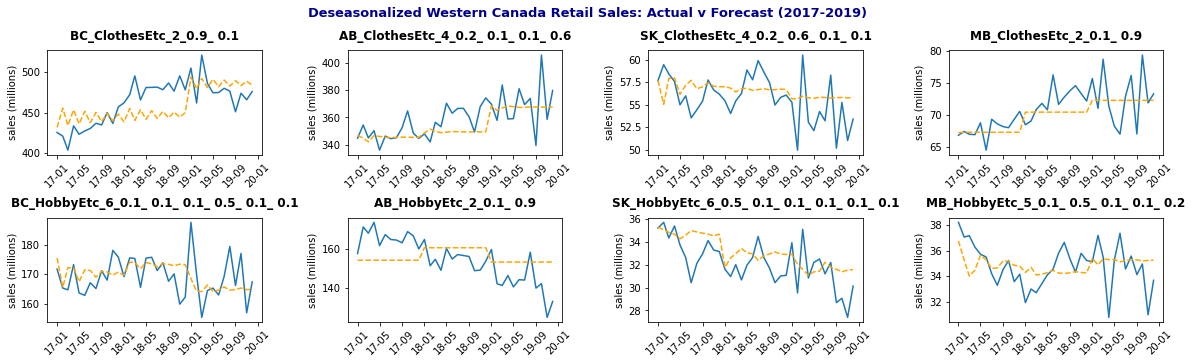

In [23]:
# visualize deseasonalized actual and forecast sales 

# convert summary statistics to a list of list in order to select respective absolute mape as well as actual and forecast sales 
stats_lol = stats_mape_df_2[ ['prv_nm','cat_nm','min_scenario'] ].values.tolist()

# create figure and axes layout
fig = plt.figure(num = 1, figsize = (30, 10), dpi = 100, facecolor = 'w', edgecolor = 'k')
fig, ax = plt.subplots(2,4, figsize = (20,5)) # axes layout with category on row and province on column 
fig.subplots_adjust(hspace=0.6, wspace=0.4)
fig.suptitle('Deseasonalized Western Canada Retail Sales: Actual v Forecast (2017-2019)', fontsize=13, y=1.0, color='darkblue', fontweight='bold')

stats_idx = 0 # initialize scenario counter

for x in stats_lol:
    
    # set province, category and scenario based on axes counter and list of list position
    prv_nm = stats_lol[stats_idx][0]
    cat_nm = stats_lol[stats_idx][1]
    scenario = stats_lol[stats_idx][2]
    
    # select sales forecast values for each province, category and scenario
    fcst_display_df = sales_forecast_df_1[(sales_forecast_df_1.prv_nm == prv_nm) & \
                                          (sales_forecast_df_1.cat_nm == cat_nm) & \
                                          (sales_forecast_df_1.fcst_scenario == scenario) & \
                                          (sales_forecast_df_1.fcst_item == 'estimate')]
    
    # logic to position visualization in respective axes of the figure by row and column
    ax_row_idx = 0 if stats_idx < 4 else 1
    ax_col_idx = stats_idx if stats_idx < 4 else stats_idx-4
    
    # plot actual and forecast sales and format
    ax[ax_row_idx, ax_col_idx].plot(fcst_display_df.date, fcst_display_df.sales_deseason)
    ax[ax_row_idx, ax_col_idx].plot(fcst_display_df.date, fcst_display_df.fcst_deseason, color="orange", linestyle='dashed')
    ax[ax_row_idx, ax_col_idx].set_title(prv_nm + "_" + cat_nm + "_" + scenario, fontweight='bold', pad=10.5)
    ax[ax_row_idx, ax_col_idx].xaxis.set_tick_params(rotation=45) 
    scale_y = 1000
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax[ax_row_idx, ax_col_idx].yaxis.set_major_formatter(ticks_y)
    ax[ax_row_idx, ax_col_idx].set_ylabel('sales (millions)')
    
    # format dates
    dateFmt = mdates.DateFormatter("%y-%m")
    ax[ax_row_idx, ax_col_idx].xaxis.set_major_formatter(dateFmt)
        
    stats_idx += 1

<Figure size 3000x1000 with 0 Axes>

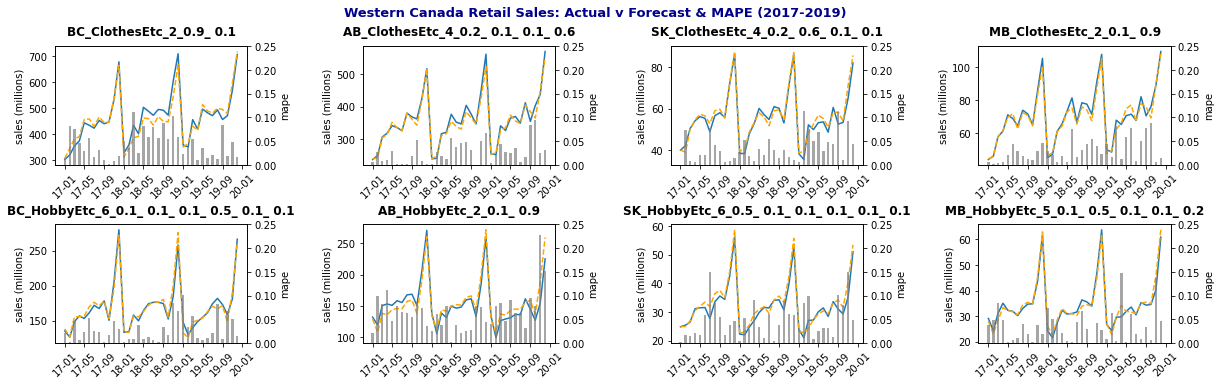

In [22]:
# visualize seasonalized forecast data with absolute mape of minimum absolute mape scenarios

# convert summary statistics to a list of list in order to select respective absolute mape as well as actual and forecast sales 
stats_lol = stats_mape_df_2[ ['prv_nm','cat_nm','min_scenario', 'min_mape'] ].values.tolist()

# create figure and axes layout
fig = plt.figure(num = 1, figsize = (30, 10), dpi = 100, facecolor = 'w', edgecolor = 'k')
fig, axes = plt.subplots(2,4, figsize = (20,5)) # axes layout with category on row and province on column 
fig.subplots_adjust(top=0.95, hspace=0.5, wspace=0.6)
fig.suptitle('Western Canada Retail Sales: Actual v Forecast & MAPE (2017-2019)', fontsize=13, y=1.06, color='darkblue', fontweight='bold')

axes_cntr = 0 # initialize axes counter

# logic to position visualization in respective axes of the figure by row and column
# note that previous method (selecting by row and column axes position) does not work with twinx overlay method    
for ax_row in axes:
    for ax in ax_row:

        # set province, category and scenario based on axes counter and list of list position
        prv_nm = stats_lol[axes_cntr][0]
        cat_nm = stats_lol[axes_cntr][1]
        scenario = stats_lol[axes_cntr][2]

        # select sales forecast values for each province, category and scenario
        fcst_display_df = sales_forecast_df_1[(sales_forecast_df_1.prv_nm == prv_nm) & \
                                              (sales_forecast_df_1.cat_nm == cat_nm) & \
                                              (sales_forecast_df_1.fcst_scenario == scenario) & \
                                              (sales_forecast_df_1.fcst_item == 'estimate')]

        ax1 = ax.twinx() # overlay axes

        # plot actual and forecast sales and format
        ax.plot(fcst_display_df.date, fcst_display_df.sales_k)
        ax.plot(fcst_display_df.date, fcst_display_df.fcst_season, color="orange", linestyle='dashed')
        ax.set_title(prv_nm + "_" + cat_nm + "_" + scenario, fontweight='bold', pad=10.5)
        ax.xaxis.set_tick_params(rotation=45) 
        scale_y = 1000
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
        ax.yaxis.set_major_formatter(ticks_y)
        ax.set_ylabel('sales (millions)')
        
        # plot absolute mape bar chart, format and set range so comparable
        ax1.bar(fcst_display_df.date, fcst_display_df.fcst_mape, width=15, color='grey', alpha=0.7) # alpha adjusts color transparency
        ax1.set_ylim([0,0.25])
        ax1.set_ylabel('mape')
        
        # format dates
        dateFmt = mdates.DateFormatter("%y-%m")
        ax1.xaxis.set_major_formatter(dateFmt)

        axes_cntr += 1